In [1]:
# !ls /root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/images/val

In [2]:
img_name = '000000006251.jpg'
data_split = 'train'

# img_name = '000000042188.jpg'
# data_split = 'test'
camera_positions = ['A_Pillar_Driver', 'Rear_Mirror', 'A_Pillar_Codriver']
camera_position = camera_positions[2]
img_path = f'/root/data/processed/synthetic_cabin_bw/{camera_position}/images/{data_split}/{img_name}'

In [3]:
from modules.human_detector.human_detector import HumanDetector

detector = HumanDetector(
    config_path='./src/modules/human_detector/config/faster_rcnn.py',
    pretrained_path="https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/"\
        "faster_rcnn_r101_caffe_fpn_1x_coco/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth",
    # pretrained_path="mmengine_workdir/human_detector/epoch_1.pth",
    checkpoint_path="mmengine_workdir/human_detector/epoch_1.pth",
    data_root_path='/root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/',
    device='cuda:0',
    working_directory='./mmengine_workdir/human_detector',
    log_level='CRITICAL'
)

detector.load_pretrained()
detector_result = detector.get_bbox(img_path)
bbox = detector_result['bboxes']
print(bbox)

Loads checkpoint by local backend from path: mmengine_workdir/human_detector/epoch_1.pth
tensor([[ 324.2157,  220.6053, 1140.3075, 1015.4211]], device='cuda:0')


/opt/conda/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


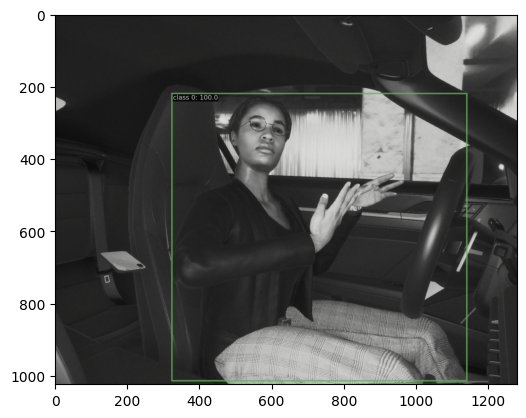

In [4]:
detector.visualise(img_path)

In [5]:
from modules.pose_estimator_2d.pose_estimator_2d import PoseEstimator2D

pose_estimator_2d = PoseEstimator2D(
    config_path='modules/pose_estimator_2d/config/hrnet.py',
    pretrained_path='https://download.openmmlab.com/mmpose/v1' \
        '/body_2d_keypoint/topdown_heatmap/coco'\
            '/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth',
    # checkpoint_path="mmengine_workdir/pose_estimator_2d/best_coco_AP_epoch_0.pth",
    checkpoint_path="mmengine_workdir/pose_estimator_2d/best_coco_AP_epoch_9.pth",
    data_root_path='/root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/',
    device='cuda:0',
    working_directory='mmengine_workdir/pose_estimator_2d',
    log_level='CRITICAL'
)

pose_estimator_2d.load_pretrained()
pose_estimator_2d_result = pose_estimator_2d.inference(img_path, bbox.detach().cpu().numpy(), bbox_format='xywh')
keypoints_2D = pose_estimator_2d_result[0].pred_instances['keypoints'][0]
print(keypoints_2D)

Loads checkpoint by local backend from path: mmengine_workdir/pose_estimator_2d/best_coco_AP_epoch_9.pth
[[ 604.83823967  334.85030222]
 [ 619.68599383  320.00254774]
 [ 560.29497719  305.15479326]
 [ 634.53374799  379.39356565]
 [ 500.90396055  349.6980567 ]
 [ 619.68599383  527.87111044]
 [ 456.36069806  557.5666194 ]
 [ 723.62027295  706.04416418]
 [ 382.12192726  706.04416418]
 [ 812.70679792  527.87111044]
 [ 693.92476463  631.80539179]
 [ 589.99048551  899.0649724 ]
 [ 471.20845222  988.15149927]
 [1020.57535617  913.91272688]
 [ 961.18433952 1017.84700823]
 [ 649.38150215  676.34865522]
 [1005.72760201  928.76048136]]


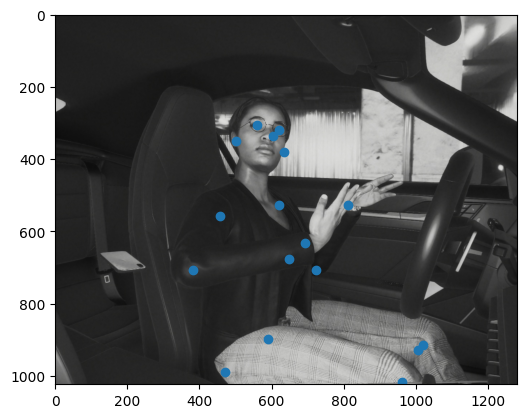

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

keypoints = pd.DataFrame(keypoints_2D, columns=['x', 'y'])

img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.scatter(keypoints['x'], keypoints['y'])
plt.show()

In [7]:
import json
import numpy as np
with open(f'/root/data/processed/synthetic_cabin_bw/{camera_position}/annotations/person_keypoints_{data_split}.json') as f:
    data = json.loads(f.readline())

annotations = {}
for id in range(len(data['images'])):
    annotations[data['images'][id]['file_name']] = {
        'keypoints': np.array(data['annotations'][id]['keypoints']).reshape(-1, 3)[:, :2]
    }

/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:680: UserWarning: Warning: The circle is out of bounds, the drawn circle may not be in the image
  warnings.warn(


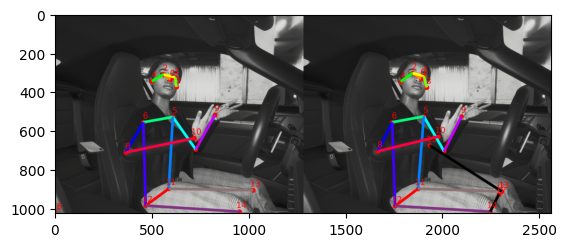

In [8]:
pose_estimator_2d.visualize(
    img_path=img_path,
    bboxes=bbox.tolist(),
    bbox_format='xywh',
    gt_keypoints=np.expand_dims(annotations[img_name]['keypoints'], 0)
)